# Gravix Layer Cookbook: AI Data Analyst Workflow
This notebook provides a comprehensive guide to building a complete **AI-powered data analysis workflow** using the **Gravix Layer** SDK for both LLM inference and secure code execution. You will learn how to create an intelligent system that generates, executes, and visualizes data analysis code automatically using advanced language models and containerized execution environments.

### What is Full Stack AI Data Analysis?
Full Stack AI Data Analysis combines the power of large language models with secure code execution to create autonomous data analysis workflows. Instead of manually writing analysis code, the system uses AI to understand your requirements, generate appropriate Python code, execute it safely in a sandbox environment, and return meaningful results with visualizations.

### In this notebook, you will learn to:
1. **Set up** the Gravix Layer environment with both chat and sandbox capabilities.
2. **Configure** intelligent code generation prompts for robust data analysis.
3. **Execute** AI-generated Python code in secure, isolated sandbox environments.
4. **Process** and display results including charts, plots, and statistical outputs.
5. **Handle** errors gracefully with automatic retry and fallback mechanisms.
6. **Integrate** multiple data sources and analysis techniques seamlessly.

### Key Features:
- **Intelligent Code Generation**: LLM-powered Python code creation for complex data analysis tasks
- **Secure Execution Environment**: Containerized sandbox execution with full dependency management
- **Automatic Visualization**: Generated charts and plots with base64 encoding for display
- **Error Handling**: Robust exception handling and debugging capabilities
- **Multi-format Output**: Support for various data formats and visualization types

### Use Cases:
- Automated exploratory data analysis and statistical modeling
- Dynamic report generation with custom visualizations
- Interactive data science workflows and hypothesis testing
- Educational data analysis demonstrations and tutorials
- Rapid prototyping of machine learning and statistical models

### Disclaimer
**This notebook demonstrates AI-powered code generation and execution for educational and development purposes. Always review generated code before production use. The sandbox environment provides isolation, but ensure your data handling complies with security and privacy requirements. Generated code may have limitations in understanding complex domain-specific requirements.**

In [7]:
pip install gravixlayer IPython


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 🔧 Setup and Configuration

First, let's import the required libraries and set up our AI-powered data analysis environment.

### Required Dependencies:
- **GravixLayer**: Both LLM client for code generation and Sandbox for secure execution
- **IPython**: Rich display capabilities for charts and visualizations
- **Base64**: Image encoding for plot display and transfer

### Security Notes:
- API keys should be stored securely in environment variables for production
- Sandbox execution provides isolation from your local environment
- All code execution happens in containerized environments

In [8]:
import os
import json
import re
from gravixlayer import GravixLayer, Sandbox
from IPython.display import Image, display
import base64 # Import for base64 handling

# API Key is hardcoded here for demo purposes
os.environ["GRAVIXLAYER_API_KEY"] = GRAVIXLAYER_API_KEY

# Choose a powerful model for code generation (supported by GravixLayer)
MODEL_NAME = "qwen/qwen3-4b-instruct-2507"

SYSTEM_PROMPT = """You are an expert Python data scientist. Your goal is to generate clean, robust, and working Python code.

**TASK CONTEXT**
- You will be given a task, typically for data analysis and visualization.
- The dataset is located at `/home/user/data.csv`.
- Key columns: 'GDP per capita (current US$)', 'Life expectancy at birth, total (years)'.

**CORE RULES**
1.  **Code Only:** Respond *ONLY* with a single Python code block. Do not add any text before or after the ```python block.
2.  **Save Plot:** You MUST save any generated plot to `/home/user/chart.png`.
3.  **Critical Output:** After saving, you MUST read the plot file, base64-encode it, and print the *exact* line: `print(f'PLOT_BASE64:<base64_string_here>')`. This is how the system finds your plot.
4.  **Robust Code:** Include error handling (`try...except`) and print statements to show progress (e.g., `df.shape`, `df_clean.shape`).

**EXAMPLE OF A PERFECT RESPONSE**

```python
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import sys
import traceback
import base64

try:
    # Load and clean data
    df = pd.read_csv('/home/user/data.csv')
    print(f"Original data shape: {df.shape}")

    # Define key columns
    gdp_col = 'GDP per capita (current US$)'
    life_exp_col = 'Life expectancy at birth, total (years)'
    
    df_clean = df[[gdp_col, life_exp_col]].dropna()

    # Convert to numeric, handling potential errors
    df_clean[gdp_col] = pd.to_numeric(df_clean[gdp_col], errors='coerce')
    df_clean[life_exp_col] = pd.to_numeric(df_clean[life_exp_col], errors='coerce')
    
    # Drop rows that failed conversion
    df_clean = df_clean.dropna()
    print(f"Clean data shape: {df_clean.shape}")

    if df_clean.empty:
        print("Error: No data left after cleaning.")
        sys.exit(1)

    # Prepare features and target
    X = df_clean[gdp_col].values.reshape(-1, 1)
    y = df_clean[life_exp_col].values

    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    print("Model fitted successfully.")

    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.6, color='blue', label='Data points')
    
    # Create line
    X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    plt.plot(X_line, model.predict(X_line), color='red', linewidth=2, label='Regression line')
    
    plt.xlabel('GDP per capita (current US$)')
    plt.ylabel('Life expectancy at birth, total (years)')
    plt.title('GDP per capita vs Life Expectancy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    plot_path = '/home/user/chart.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {plot_path}")

    # Read the saved image, encode it, and print the base64 string
    with open(plot_path, 'rb') as f:
        image_bytes = f.read()
        base64_string = base64.b64encode(image_bytes).decode('utf-8')
        # This is the most important line:
        print(f'PLOT_BASE64:{base64_string}')

except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()

```
"""

## 🛠️ AI Code Execution Utilities

These utility functions handle the complex task of executing AI-generated code in secure sandbox environments. The system manages:
- **Secure Execution**: All code runs in isolated containers
- **Output Parsing**: Extracting results, plots, and error messages
- **Base64 Handling**: Converting generated plots for display
- **Error Recovery**: Graceful handling of execution failures

### Key Functions:
1. **`code_interpret()`**: Execute code in Gravix Layer sandbox with output capture
2. **`chat_with_llm()`**: Generate and execute data analysis code using LLM
3. **`upload_dataset()`**: Securely transfer data files to sandbox environment
4. **Plot extraction helpers**: Parse base64-encoded visualizations from output

In [9]:
def code_interpret(gravix_sandbox, code):
    print("\n--- Running Code in Gravix Layer Sandbox ---")
    result = gravix_sandbox.run_code(code)
    
    # Safely get stdout, stderr, and error
    stdout = getattr(result, 'stdout', '')
    stderr = getattr(result, 'stderr', '')
    error = getattr(result, 'error', None)
    
    if stdout:
        print("[Sandbox STDOUT]:")
        print(stdout)
    else:
        print("[Sandbox STDOUT]: (No stdout)")

    if stderr:
        print("\n[Sandbox STDERR]:")
        print(stderr)
    
    if error:
        print("\n[Sandbox Execution Error]:")
        print(error)
        
    print("--- End Sandbox Run ---")
    
    # Return stdout for parsing, as it contains the print() statements
    return stdout

In [10]:
try:
    client = GravixLayer()
except Exception as e:
    print(f"Failed to initialize GravixLayer client: {e}")
    client = None

pattern = re.compile(r"```python\n(.*?)\n```", re.DOTALL)

def match_code_blocks(llm_response):
    match = pattern.search(llm_response)
    if match:
        code = match.group(1)
        print("Generated code:")
        print(code)
        return code
    return ""

def chat_with_llm(gravix_sandbox, user_message):
    if not client:
        print("GravixLayer client is not initialized.")
        return None

    print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_message},
    ]

    print("Gravix AI is thinking...")
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

    response_message = response.choices[0].message
    python_code = match_code_blocks(response_message.content)
    
    plot_base64 = None
    if python_code:
        # code_output_string is the full stdout from the sandbox
        code_output_string = code_interpret(gravix_sandbox, python_code)
        
        if code_output_string:
            # Search for the plot path within the entire stdout string, line by line
            for line in code_output_string.splitlines():
                if line and "PLOT_BASE64:" in line:
                    plot_base64 = line.split("PLOT_BASE64:", 1)[1].strip()
                    print(f"Detected plot base64 string (truncated): {plot_base64[:50]}...")
                    break # Found it
        return plot_base64
    else:
        print(f"No Python code found in response: {response_message.content}")
        return None

In [11]:
def upload_dataset(gravix_sandbox):
    print("Uploading dataset to Gravix Layer sandbox...")
    local_path = "./data.csv"
    remote_path = "/home/user/data.csv"

    if not os.path.exists(local_path):
        print(f"Dataset file not found at {local_path}")
        return None

    try:
        with open(local_path, "r", encoding="utf-8") as f:
            content = f.read()
        
        gravix_sandbox.write_file(remote_path, content)
        print("Uploaded at", remote_path)
        return remote_path
    except Exception as error:
        print("Error during file upload:", error)
        raise error

## Complete AI Data Analysis Workflow

Now let's run the complete AI-powered data analysis workflow. This will:

1. **Initialize** secure sandbox environment with dependency installation
2. **Upload** dataset to the isolated execution environment  
3. **Generate** Python code using advanced language models
4. **Execute** code safely in containerized sandbox
5. **Extract** and display generated visualizations

### Expected Output:
- **Code Generation**: AI-generated Python code for data analysis
- **Execution Logs**: Real-time output from sandbox execution
- **Visualization**: Generated chart displayed inline in the notebook

Uploading dataset to Gravix Layer sandbox...
Uploaded at /home/user/data.csv

--- Installing Dependencies in Sandbox via APK ---
This may take a few minutes...
Running: apk add py3-pandas py3-matplotlib py3-scikit-learn
[apk STDOUT]:
 fetch https://dl-cdn.alpinelinux.org/alpine/v3.19/main/x86_64/APKINDEX.tar.gz
fetch https://dl-cdn.alpinelinux.org/alpine/v3.19/community/x86_64/APKINDEX.tar.gz
(1/131) Installing py3-cairo-pyc (1.25.1-r0)
(2/131) Installing py3-certifi (2024.2.2-r0)
(3/131) Installing py3-certifi-pyc (2024.2.2-r0)
(4/131) Installing libquadmath (13.2.1_git20231014-r0)
(5/131) Installing libgfortran (13.2.1_git20231014-r0)
(6/131) Installing openblas (0.3.25-r0)
(7/131) Installing py3-numpy (1.25.2-r0)
(8/131) Installing py3-numpy-pyc (1.25.2-r0)
(9/131) Installing py3-contourpy (1.2.0-r0)
(10/131) Installing py3-contourpy-pyc (1.2.0-r0)
(11/131) Installing py3-cycler (0.12.1-r0)
(12/131) Installing py3-cycler-pyc (0.12.1-r0)
(13/131) Installing py3-six (1.16.0-r8)
(14/13

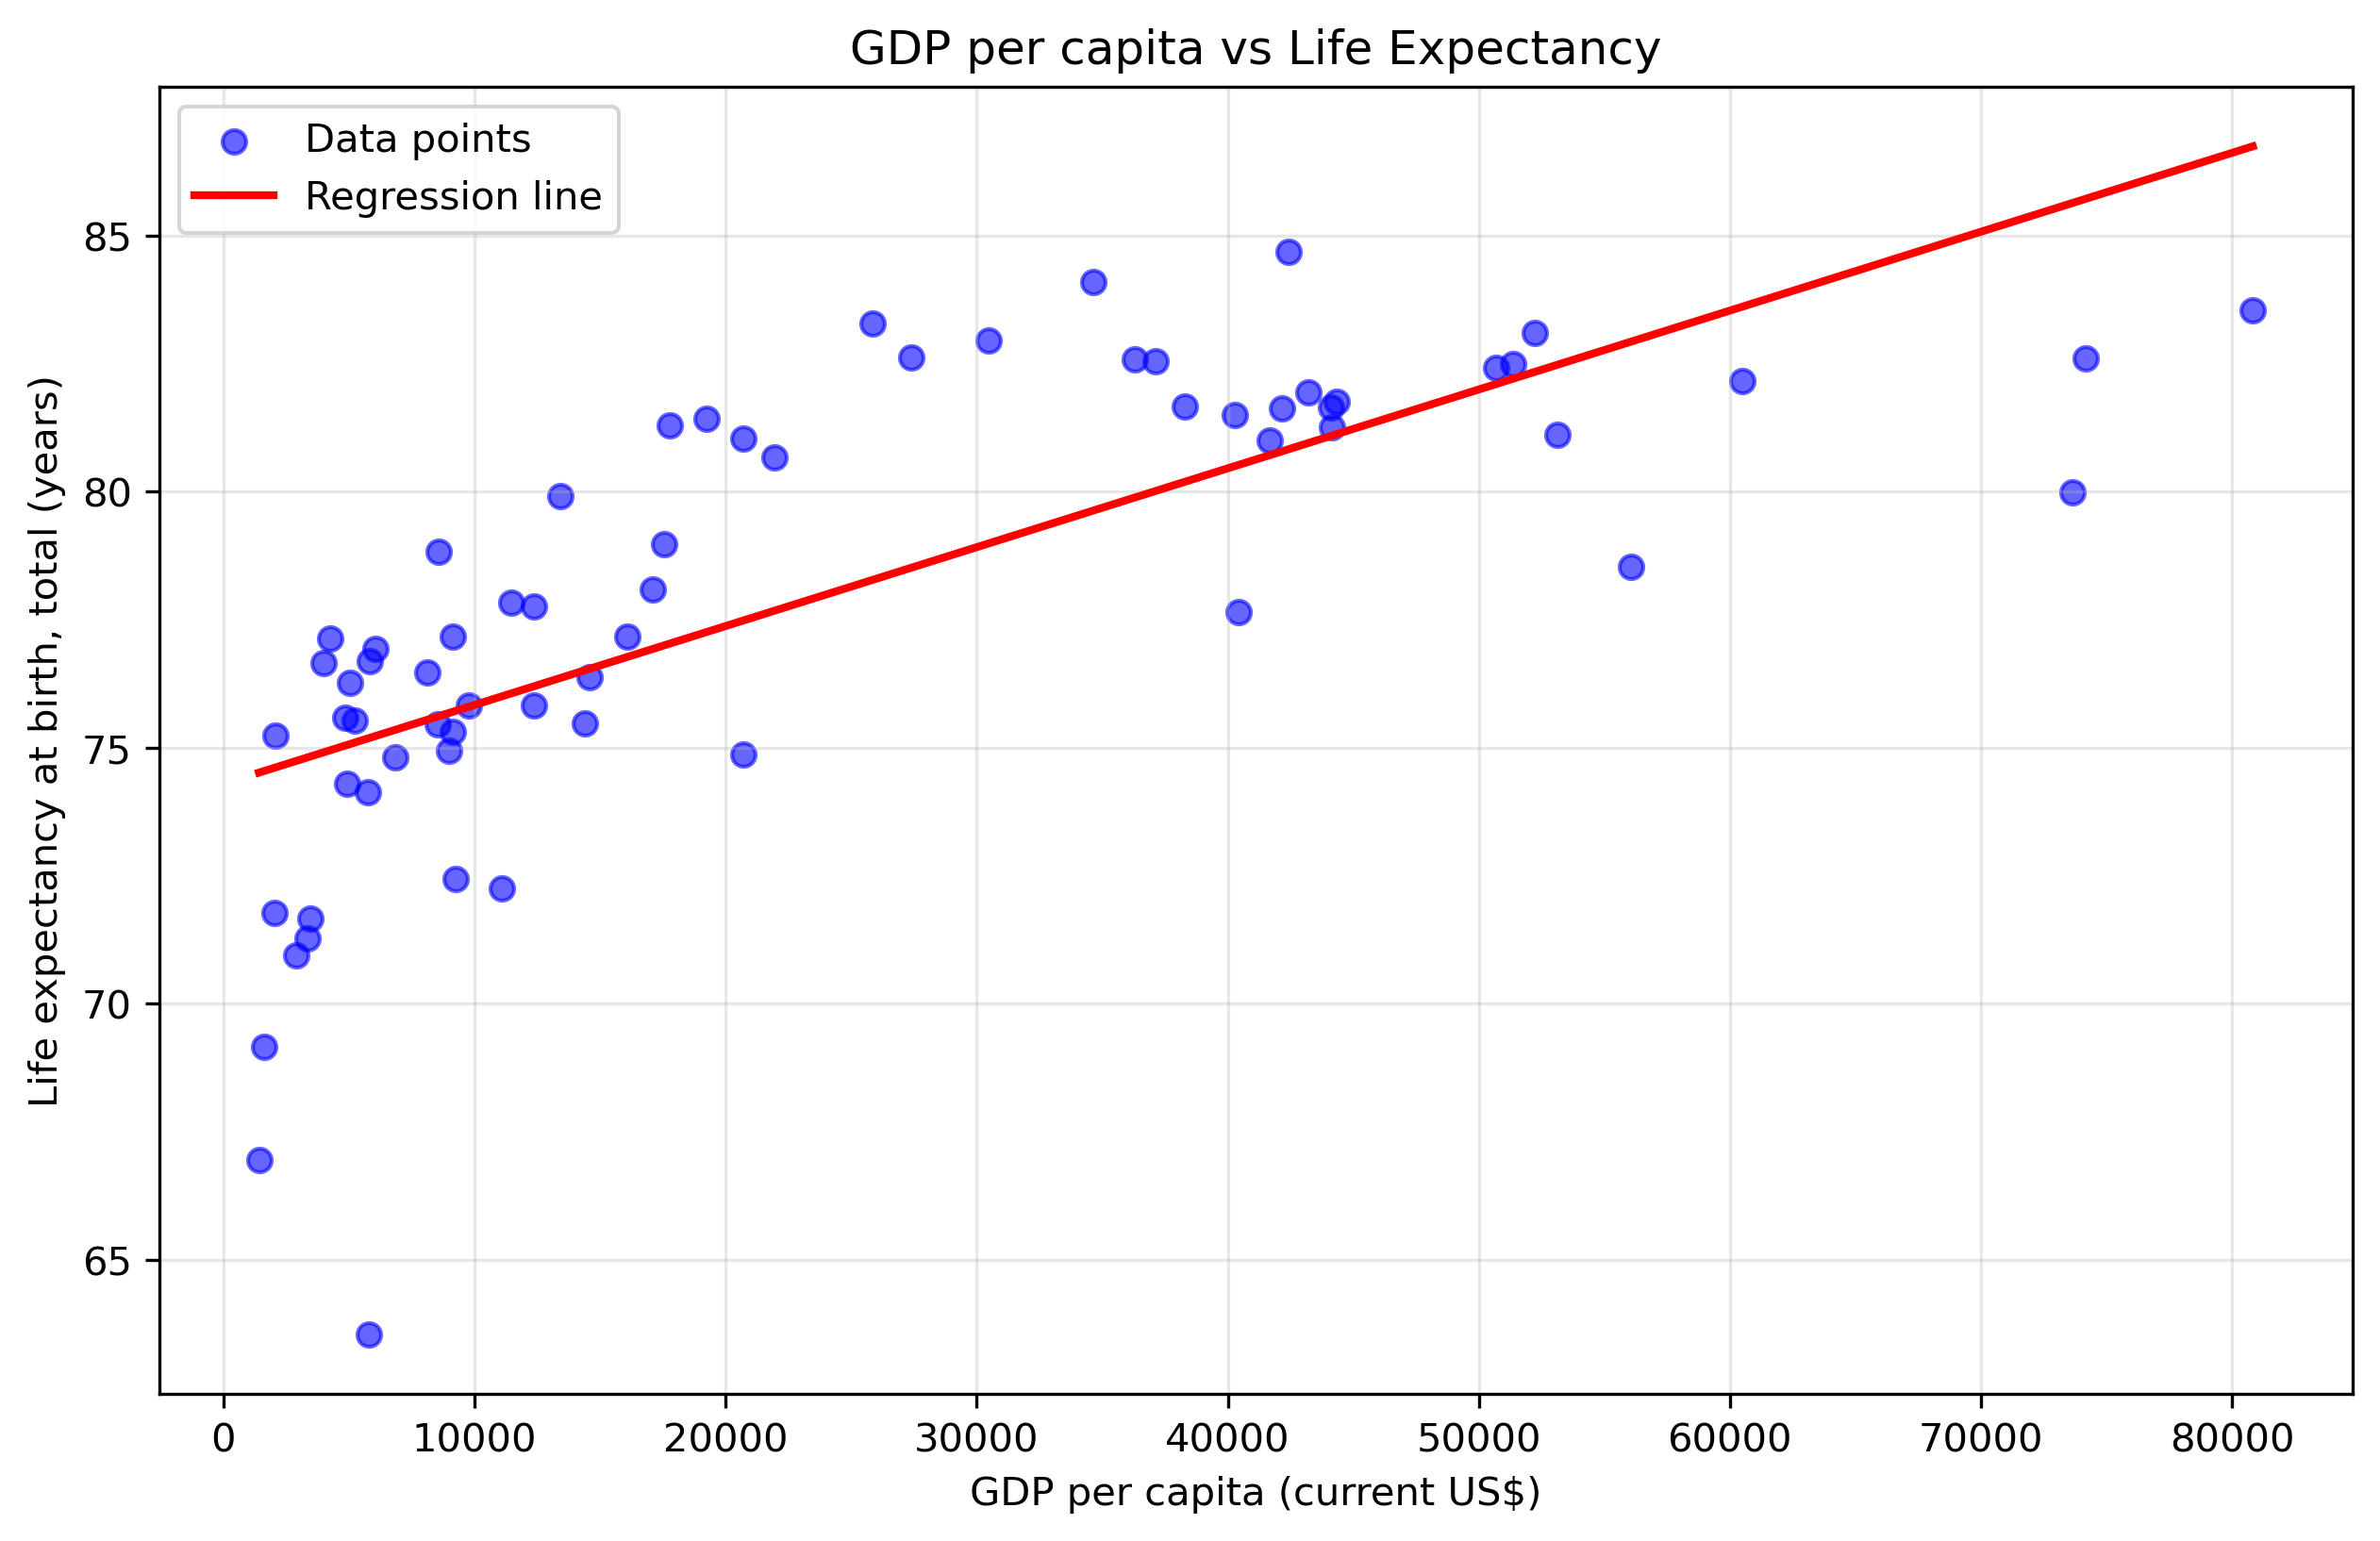

In [12]:
try:
    with Sandbox.create() as sandbox:
        if not upload_dataset(sandbox):
            raise Exception("Dataset upload failed. Aborting.")

        # --- NEW STEP: Install dependencies ---
        print("\n--- Installing Dependencies in Sandbox via APK ---")
        print("This may take a few minutes...")
        
        # Install pre-compiled Python libraries from Alpine's package manager
        # This is much faster and more reliable than using pip to build from source
        print("Running: apk add py3-pandas py3-matplotlib py3-scikit-learn")
        install_result = sandbox.run_command("apk", ["add", "py3-pandas", "py3-matplotlib", "py3-scikit-learn"], timeout=300)
        
        if install_result.stdout:
            print("[apk STDOUT]:\n", install_result.stdout)
        if install_result.stderr:
            print("[apk STDERR]:\n", install_result.stderr)
            
        if install_result.exit_code == 0:
            print("--- Dependency Installation Complete ---")
        else:
            print("[apk ERROR]:", getattr(install_result, 'error', 'No error attribute'))
            raise Exception("System library installation (apk) failed. Aborting.")
        # --- End New Step ---

        # This prompt is clear and maps to the system prompt's example
        user_task = "Create a linear regression chart: GDP per capita vs life expectancy. Clean data, show scatter + regression line."
        
        plot_base64_data = chat_with_llm(
            sandbox,
            user_task,
        )
        
        if plot_base64_data:
            print(f"\n--- Decoding and displaying plot ---")
            try:
                # *** FIX HERE ***
                # Decode the base64 string (str) back into bytes
                image_bytes = base64.b64decode(plot_base64_data)
                # Pass the raw bytes to Image()
                display(Image(data=image_bytes))
            except Exception as e:
                print(f"\nError displaying base64 image: {e}")
        else:
            print("\n--- No plot was generated by the AI (base64 string not found in output) ---")

except Exception as e:
    print(f"\n--- An error occurred during the sandbox operation --- ")
    print(f"Error: {e}")
    print("Please ensure your GRAVIXLAYER_API_KEY is valid and data.csv exists.")

## Conclusion

### What We've Accomplished

In this comprehensive cookbook, we've built a complete AI-powered data analysis ecosystem:

1. **Intelligent Code Generation** - LLM-powered Python code creation for complex data analysis
2. **Secure Execution Environment** - Containerized sandbox execution with full isolation
3. **Automated Visualization** - AI-generated charts and plots with seamless display
4. **End-to-End Workflow** - From data upload to final visualization in one pipeline

### The Power of AI-Driven Data Analysis

This approach represents a fundamental shift in data science workflows:

- **Accessibility**: Makes advanced data analysis available to non-programmers
- **Efficiency**: Eliminates manual coding for routine analysis tasks
- **Safety**: Sandbox execution prevents code from affecting local environment
- **Scalability**: Can handle multiple datasets and analysis types simultaneously
- **Reproducibility**: Generated code can be saved and reused for similar analyses

### Next Steps

To extend your AI data analysis capabilities:

1. **Custom Prompts** - Develop specialized prompts for domain-specific analyses
2. **Multi-Dataset Analysis** - Extend to handle multiple data sources simultaneously
3. **Advanced Models** - Experiment with different LLMs for specialized tasks
4. **Production Deployment** - Add monitoring, logging, and enterprise security features

### Key Takeaways

- **AI code generation enables rapid prototyping** - From idea to visualization in minutes
- **Sandbox execution ensures safety** - No risk to local environment or data
- **Structured prompts improve results** - Clear instructions lead to better generated code
- **Base64 encoding enables seamless visualization** - Charts display directly in notebooks